# Initial conditions

In [13]:
epsilon = 30.5 # area ratio, коэффициент расширения, отношение площади выходного сечения к площади сечения горловины
r_throat_mm = 38.1/2.0 # throat diameter, диаметр горловины
r_throat = 1.0
l=11.94

# Truncated Ideal Contoured, TIC

# Thrust Optimized Contoured, TOC, Rao

Rao’s method, based on Method of Characteristics, MOC

# Thrust Optimized Parabolic, TOP

In [14]:
import numpy as np
from math import sin, cos, radians, sqrt, tan
%matplotlib widget

In [15]:
theta0_deg = 40
x1 = 0.382*sin(radians(theta0_deg))
y1 = 1.0 + (1.0 - cos(radians(theta0_deg)))
x2 = 0.79*14.93
y2 = sqrt(epsilon)
print(x1, x2, y1, y2)

0.245544866900258 11.7947 1.233955556881022 5.522680508593631


Уравнение наклонной параболы:

https://www.anirdesh.com/math/algebra/parabola-rotation.php

Касательная (тагенс угла наклона) наклонной параболы:

${tan(\alpha)=\dfrac{\partial y}{\partial x}=\dfrac{\partial y}{\partial f(x,y)} \cdot \dfrac{\partial f(x,y)}{\partial x}}$

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html#scipy.optimize.root

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html

In [1]:
import sympy
from sympy import *
x_sym, y_sym, a_sym, b_sym, c_sym, t_sym = symbols('x y a b c \\vartheta')
sympy.init_printing()
x_sym, y_sym, a_sym, b_sym, c_sym, t_sym

In [2]:
# tilted parabola equation
til_par_eqn = (a_sym*(x_sym*cos(t_sym) + y_sym*sin(t_sym))**2
        - (y_sym*cos(t_sym) - x_sym*sin(t_sym))
        + b_sym*(x_sym*cos(t_sym) + y_sym*sin(t_sym))
        + c_sym)
til_par_eqn

-(a*x*cos(2*\vartheta) + a*x + a*y*sin(2*\vartheta) + b*cos(\vartheta) + sin(\vartheta))/(a*x*sin(2*\vartheta) + 2*a*y*sin(\vartheta)**2 + b*sin(\vartheta) - cos(\vartheta))


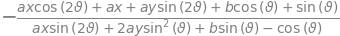

In [35]:
# dF_dx = diff(til_par_eqn, x_sym)
dF_dx = idiff(til_par_eqn, y_sym, x_sym).simplify()
print(dF_dx)
dF_dx

(-a*x*sin(2*\vartheta) - 2*a*y*sin(\vartheta)**2 - b*sin(\vartheta) + cos(\vartheta))/(2*a*x*cos(\vartheta)**2 + a*y*sin(2*\vartheta) + b*cos(\vartheta) + sin(\vartheta))


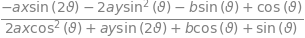

In [36]:
# dF_dy = diff(til_par_eqn, y_sym)
dF_dy = idiff(til_par_eqn, x_sym, y_sym).simplify()
print(dF_dy)
dF_dy

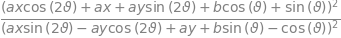

In [37]:
dy_dx = dF_dx/dF_dy
dy_dx.simplify()

In [16]:
# вектор состояния параболы p = [a, h, k, theta]

def system_of_equations(p, *args):
    """
    вектор параметров наклонной параболы p = [a, b, c, theta]
    в уравнении -x*sin(theta)+y*cos(theta)=a*(x*cos(theta)+y*sin(theta)-h)**2+k
    a(x*cos(theta) + y*sin(theta))**2 - (y*cos(theta) - x*sin(theta)) + b(x*cos(theta) + y*sin(theta)) + c = 0
    """
    a = p[0]
    b = p[1]
    c = p[2]
    theta = p[3]
    
    x1 = args[0]
    x2 = args[1]
    y1 = args[2]
    y2 = args[3]
    
    tilted_parabola = lambda x, y: (
        a*(x*cos(theta) + y*sin(theta))**2
        - (y*cos(theta) - x*sin(theta))
        + b*(x*cos(theta) + y*sin(theta))
        + c)
    
    # tilted_parabola_ddx = lambda x, y: (
    #     a * x**2 * cos(theta)**2 + a*y**2 * sin(theta)**2 + 2 * a * x * y * cos(theta) * sin(theta)
    #     - y*cos(theta) + x*sin(theta)
    #     + b*x*cos(theta) + b*y*sin(theta)
    #     + c)
    tilted_parabola_ddx = lambda x, y: (
        2*a*(x*cos(theta) + y*sin(theta))*cos(theta)
        + b*cos(theta) + sin(theta)
    )
    # tilted_parabola_ddy = lambda x, y: (
    #     2.0*a*y*sin(theta)**2 + 2.0 * a * x * cos(theta) * sin(theta)
    #     - cos(theta)
    #     + b*sin(theta)
    # )
    tilted_parabola_ddy = lambda x, y: (
        2*a*(x*cos(theta) + y*sin(theta))*sin(theta)
        + b*sin(theta) - cos(theta)
    )
    return [tilted_parabola(x1, y1), # координаты в стартовой точке
            tilted_parabola(x2, y2), # координаты в финальной точке
            tilted_parabola_ddx(x1, y1)/tilted_parabola_ddy(x1, y1) - tan(radians(40.0)),  # наклон в стартовой точке
            tilted_parabola_ddx(x2, y2)/tilted_parabola_ddy(x2, y2) - tan(radians(8.0))]  # наклон в финальной точке


In [22]:
from scipy.optimize import fsolve, root
# solution = fsolve(system_of_equations, [0.1, 0.1, 0.1, -3.14], args=(x1, x2, y1, y2))
# solution
solution = root(system_of_equations, [0.1, 0.1, 0.1, 0.0], args=(x1, x2, y1, y2), method='krylov', tol=1e-05)
solution.x

# наилучшие результаты: krylov, hybr

array([-0.13176528, -4.81873144, -5.37269576, -1.46482211])

In [23]:
# построение точек профиля
x_range = np.linspace(start = x1, stop = x2, num = 100)

def tilted_parabola_fn(x, y, params):
    """
    params = [a, b, c, theta]
    """
    a = params[0]
    b = params[1]
    c = params[2]
    theta = params[3]

    result = (
        a*(x*cos(theta) + y*sin(theta))**2
        - (y*cos(theta) - x*sin(theta))
        + b*(x*cos(theta) + y*sin(theta))
        + c)
    return result

# y_sln = root(lambda y: tilted_parabola_fn(x = 2.0, y = y, params=solution.x), 0.0, method='hybr')
# y_sln.x[0]

def implicit_y_approximator(x, params):
    y_sln = root(lambda y: tilted_parabola_fn(x = x, y = y, params=params), 0.0)
    return y_sln.x[0]
    
# y_vectorized_approximator = np.vectorize(implicit_y_approximator)
y_approximated = np.array([implicit_y_approximator(x, solution.x) for x in x_range])
y_approximated

array([1.26827805, 1.30760253, 1.34697042, 1.38638194, 1.42583729,
       1.4653367 , 1.50488037, 1.54446853, 1.58410139, 1.62377918,
       1.66350212, 1.70327043, 1.74308435, 1.78294409, 1.8228499 ,
       1.86280199, 1.90280062, 1.94284601, 1.9829384 , 2.02307804,
       2.06326516, 2.10350002, 2.14378285, 2.18411391, 2.22449345,
       2.26492172, 2.30539897, 2.34592547, 2.38650148, 2.42712726,
       2.46780306, 2.50852917, 2.54930584, 2.59013336, 2.63101199,
       2.67194202, 2.71292371, 2.75395736, 2.79504325, 2.83618166,
       2.87737288, 2.91861721, 2.95991495, 3.00126638, 3.04267181,
       3.08413155, 3.12564589, 3.16721516, 3.20883966, 3.2505197 ,
       3.2922556 , 3.3340477 , 3.3758963 , 3.41780173, 3.45976434,
       3.50178444, 3.54386239, 3.58599851, 3.62819315, 3.67044666,
       3.71275939, 3.75513169, 3.79756392, 3.84005645, 3.88260963,
       3.92522383, 3.96789943, 4.01063681, 4.05343633, 4.09629839,
       4.13922338, 4.18221168, 4.22526369, 4.26837981, 4.31156

In [24]:
test_array = [
    [0.0,	0.964],
    [0.1,	0.964],
    [0.2,	1.043],
    [0.3,	1.123],
    [0.4,	1.203],
    [0.5,	1.256],
    [0.6,	1.362],
    [0.7,	1.441],
    [0.8,	1.521],
    [0.9,	1.574],
    [1.0,	1.654],
    [1.1,	1.733],
    [1.2,	1.813],
    [1.3,	1.866],
    [1.4,	1.945],
    [1.5,	2.025],
    [1.6,	2.078],
    [1.7,	2.158],
    [1.8,	2.211],
    [1.9,	2.264],
    [2.0,	2.343],
    [2.1,	2.396],
    [2.2,	2.449],
    [2.3,	2.503],
    [2.4,	2.582],
    [2.5,	2.635],
    [2.6,	2.688],
    [2.7,	2.741],
    [2.8,	2.794],
    [2.9,	2.847],
    [3.0,	2.874],
    [3.1,	2.954],
    [3.2,	2.980],
    [3.3,	3.060],
    [3.4,	3.113],
    [3.5,	3.139],
    [3.6,	3.219],
    [3.7,	3.272],
    [3.8,	3.272],
    [3.9,	3.325],
    [4.0,	3.405],
    [4.1,	3.431],
    [4.2,	3.484],
    [4.3,	3.537],
    [4.4,	3.537],
    [4.5,	3.590],
    [4.6,	3.643],
    [4.7,	3.696],
    [4.8,	3.723],
    [4.9,	3.749],
    [5.0,	3.802],
    [5.1,	3.856],
    [5.2,	3.882],
    [5.3,	3.909],
    [5.4,	3.962],
    [5.5,	3.988],
    [5.6,	4.041],
    [5.7,	4.068],
    [5.8,	4.094],
    [5.9,	4.121],
    [6.0,	4.147],
    [6.1,	4.174],
    [6.2,	4.227],
    [6.3,	4.227],
    [6.4,	4.280],
    [6.5,	4.280],
    [6.6,	4.333],
    [6.7,	4.386],
    [6.8,	4.386],
    [6.9,	4.439],
    [7.0,	4.466],
    [7.1,	4.492],
    [7.2,	4.519],
    [7.3,	4.545],
    [7.4,	4.598],
    [7.5,	4.598],
    [7.6,	4.651],
    [7.7,	4.651],
    [7.8,	4.678],
    [7.9,	4.704],
    [8.0,	4.731],
    [8.1,	4.758],
    [8.2,	4.758],
    [8.3,	4.811],
    [8.4,	4.837],
    [8.5,	4.864],
    [8.6,	4.890],
    [8.7,	4.917],
    [8.8,	4.917],
    [8.9,	4.943],
    [9.0,	4.996],
    [9.1,	4.970],
    [9.2,	4.996],
    [9.3,	5.023],
    [9.4,	5.049],
    [9.5,	5.076],
    [9.6,	5.076],
    [9.7,	5.129],
    [9.8,	5.129],
    [9.9,	5.129],
    [10.0,	5.155],
    [10.1,	5.182],
    [10.2,	5.182],
    [10.3,	5.235],
    [10.4,	5.235],
    [10.5,	5.235],
    [10.6,	5.288],
    [10.7,	5.288],
    [10.8,	5.288],
    [10.9,	5.315],
    [11.0,	5.341],
    [11.1,	5.341],
    [11.2,	5.341],
    [11.3,	5.394],
    [11.4,	5.394],
    [11.5,	5.394],
    [11.6,	5.394],
    [11.7,	5.447],
    [11.8,	5.447],
    [11.9,	5.447],
]

In [25]:
test_array = np.array(test_array, dtype=np.float64)

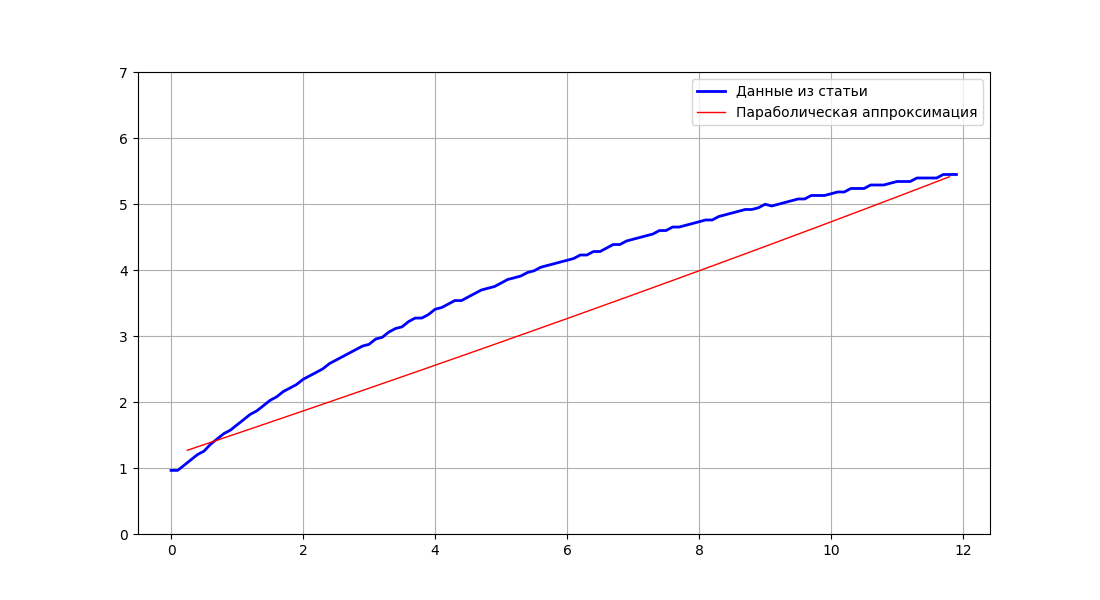

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(11, 6))
plt.plot(test_array[:,0], test_array[:,1], '-b', linewidth=2, markersize=3, label='Данные из статьи')
plt.plot(x_range, y_approximated, '-r', linewidth=1, markersize=3, label='Параболическая аппроксимация')

plt.axis('equal')
plt.ylim([0.0, 7.0])
plt.legend()
plt.grid()